# Notebook configuration

In [1]:
import glob

run_number    = 4446
inputfiles = glob.glob("/Users/ansimez/Documents/InvCit/hdf5/{}/sipm_dst/sipm_dst_*.h5".format(run_number))

# Dorothea cut analysis

In [3]:
import os
import functools
import itertools
import time
print("Running on ", time.asctime())

import numpy             as np
import tables            as tb
import matplotlib.pyplot as plt

import invisible_cities.reco.pmaps_functions  as pmapsf
import invisible_cities.filters.s1s2_filter as s1s2filt
import invisible_cities.database.load_db as dbf
import invisible_cities.reco.xy_algorithms as xyf
import invisible_cities.reco.corrections    as corrf
import invisible_cities.core.core_functions as coref
import invisible_cities.core.fit_functions  as fitf
import invisible_cities.reco.dst_functions as dstf

from invisible_cities.icaro.hst_functions import hist
from invisible_cities.icaro.hst_functions import hist2d
from invisible_cities.icaro.hst_functions import hist2d_profile
from invisible_cities.icaro.hst_functions import labels

from invisible_cities.reco.tbl_functions     import get_event_numbers_and_timestamps_from_file_name
from invisible_cities.core.system_of_units_c import units

import lmfit.models as lmf

Running on  Thu Jul 20 15:46:08 2017


#### General plotting options

In [4]:
%matplotlib inline

np.warnings.filterwarnings('ignore')

plt.rcParams["figure.figsize"]          = 8, 6
plt.rcParams["font.size"]               = 15
plt.rcParams["figure.max_open_warning"] = 100

profOpt = "--k"
fitOpt  = "r"

#### Load PMT and SiPM info

In [5]:
DataSiPM = dbf.DataSiPM(run_number)
DataPMT = dbf.DataPMT(run_number)

#### General plots

In [6]:
def plot_var(s2ec, s2ea, x, y, r, z, sipmC, nsipm):    

    hist(s2ec, 100, [np.min(s2ec), np.max(s2ec)], weights = 1/nsipm);
    labels("pes", "Entries", "S2 cathode energy")
    plt.ticklabel_format(style="sci", axis='x', scilimits=[0,0])

    hist(s2ea, 100, [np.min(s2ea), np.max(s2ea)], weights = 1/nsipm);
    labels("pes", "Entries", "S2 anode energy")
    plt.ticklabel_format(style="sci", axis='x', scilimits=[0,0])
    
    hist(x, 100 , [-200., 200.], weights = 1/nsipm)
    labels("X (mm)", "Entries", "X distribution")
    
    hist(y, 100 , [-200., 200.], weights = 1/nsipm)
    labels("Y (mm)", "Entries", "Y distribution")
    
    hist(z, 600, [0., 600.], weights = 1/nsipm)
    labels("Z (mm)", "Entries", "Z distribution")
    
    hist(r, 200, [0., 200.], weights = 1/nsipm)
    labels("R (mm)", "Entries", "R distribution")
    
    hist(sipmC, 200, [np.min(sipmC),np.max(sipmC)])
    labels("SiPM charge (pes)", "Entries", "SiPM Charge distribution")
    
    hist2d(x, y, 50, [[-200., 200.],[-200.,200.]], weights = 1/nsipm)
    labels("X (mm)", "Y (mm)", "XY distribution")
    #### General plots
    hist2d(r, s2ec, 50, [[0.,200.], [np.min(s2ec), np.max(s2ec)]], weights = 1/nsipm)
    labels("R (mm)", "Cathode energy", "S2 Cathode vs R")
    
    hist2d(r, s2ea, 50, [[0.,200.], [np.min(s2ea), np.max(s2ea)]], weights = 1/nsipm)
    labels("R (mm)", "Anode energy", "S2 Anode vs R")
    
    hist2d(z, s2ec, 50, [[0.,600.], [np.min(s2ec), np.max(s2ec)]], weights = 1/nsipm)
    labels("Z (mm)", "Cathode energy", "S2 Cathode vs Z")
    
    hist2d(z, s2ea, 50, [[0.,600.], [np.min(s2ea), np.max(s2ea)]], weights = 1/nsipm)
    labels("Z (mm)", "Anode energy", "S2 Anode vs Z")

#### Function to calculate lifetime

In [7]:
def lifetime_calculation(z, zrange, energy, erange):
    hist(energy, 50, erange)
    labels("S2 energy (pes)", "Entries", "Fidualized energy spectrum")

    low_cut   = 11000 * np.exp(-0.0009*z)
    high_cut  = 14000 * np.exp(-0.0009*z)
    sel       = coref.in_range(energy, low_cut, high_cut) # remove low and high E background

    hist2d(z, energy, (100, 50), range=(zrange, erange))
    x, y, u_y = fitf.profileX(z[sel], energy[sel], 100, xrange=zrange, yrange=erange)

    plt.plot(x, y, profOpt)
    plt.plot(z,  low_cut, "k.")
    plt.plot(z, high_cut, "k.")

    Zrange_LT = 50, 350
    
    seed = np.max(y), (x[15] - x[5])/np.log(y[15]/y[5])
    f    = fitf.fit(fitf.expo, x, y, seed, fit_range=Zrange_LT, sigma=u_y)

    plt.plot(x, f.fn(x), fitOpt)
    print("Energy at z=0 = {:.1f} +- {:.1f}".format( f.values[0], f.errors[0]))
    print("Lifetime      = {:.1f} +- {:.1f}".format(-f.values[1], f.errors[1]))
    print("Chi2          = {:.2f}          ".format(f.chi2))

    labels("Drift time ($\mu$s)", "S2 energy (pes)", "Fiducialized energy spectrum vs Z")

    return corrf.LifetimeCorrection(-f.values[1], f.errors[1])

#### Function to calculate the sigma of maps

In [8]:
def diff_calculation(xc, yc, Ec, Ece, verbosity = False):
    xproj = [np.sum(Ec[:,i]) for i in range(len(Ec))]
    yproj = [np.sum(Ec[i,:]) for i in range(len(Ec))]
    xproj_e = [np.sum(Ece[:,i]) for i in range(len(Ece))]
    yproj_e = [np.sum(Ece[i,:]) for i in range(len(Ece))]
    
    hist(xc, len(xc), [np.min(xc), np.max(xc)], weights = xproj)
    labels("X (mm)", "Mean charge", "Charge profile X projection")
    
    voigt_mod = lmf.VoigtModel()
    const_mod = lmf.ConstantModel()

    pars = const_mod.make_params(independent_vars = xproj[0])
    pars += voigt_mod.guess(xproj, x=xc)
    
    mod = const_mod + voigt_mod
    fx  = mod.fit(xproj, pars, x=xc)

    plt.plot(xc, fx.best_fit, fitOpt)

#    print(fx)
#    print(fx.amplitude_0.value)
    if verbosity:
        print("X DIMENSION")
        print(fx.fit_report())
#        print("Constant noise = {:.1f}".format(fx.amplitude_0.value))
#        print("Max signal at {:.1f}".format(fx.x_0_1.value))
#        print("FWHM = {:.1f}".format(np.abs(fx.fwhm_G_1.value)))

    hist(yc, len(yc), [np.min(yc), np.max(yc)], weights = yproj)
    labels("Y (mm)", "Mean charge", "Charge profile Y projection")
    
    pars = const_mod.make_params(independent_vars = yproj[0])
    pars += voigt_mod.guess(yproj, x=yc)
    
    mod = const_mod + voigt_mod
    fy  = mod.fit(yproj, pars, x=yc)
    
    plt.plot(yc, fy.best_fit, fitOpt)
    if verbosity:
        print("Y DIMENSION")
        print(fy.fit_report())
#        print("Constant noise = {:.1f}".format(fy.amplitude_0.value))
#        print("Max signal at {:.1f}".format(fy.x_0_1.value))
#        print("FWHM = {:.1f}".format(np.abs(fy.fwhm_G_1.value)))
    return [np.abs(fx.best_values['sigma']), np.abs(fy.best_values['sigma'])], [fx.best_values['c'], fy.best_values['c']]
#return [np.abs(2*fx.best_values['sigma']*np.sqrt(2*np.log(2))), np.abs(2*fy.best_values['sigma']*np.sqrt(2*np.log(2)))], [fx.best_values['c'], fy.best_values['c']]

In [79]:
def diff_calculation(xc, yc, Ec, Ece, verbosity = False):
    xproj = [np.sum(Ec[:,i]) for i in range(len(Ec))]
    yproj = [np.sum(Ec[i,:]) for i in range(len(Ec))]
    xproj_e = [np.sum(Ece[:,i]) for i in range(len(Ece))]
    yproj_e = [np.sum(Ece[i,:]) for i in range(len(Ece))]
    
    hist(xc, len(xc), [np.min(xc), np.max(xc)], weights = xproj)
    labels("X (mm)", "Mean charge", "Charge profile X projection")
    
    seed = 0., (np.max(xc)-np.min(xc)), 13.5, 10.
    print(seed)
#    fx    = fitf.fit(voigt, xc, xproj, seed=seed)    
    t_init = voigt(0., (np.max(xc)-np.min(xc)), 13.5, 10., xproj[0])
    fx = fitting.LevMarLSQFitter()
    t = fx(t_init,xc, xproj)
    #    seed = xproj[0], np.max(xproj) - xproj[0], 0., 10.
#    fx    = fitf.fit(back_gauss, xc, xproj, seed=seed)    
    plt.plot(xc, t(xc), fitOpt)
#    plt.plot(xc, f.fn(xc), fitOpt)
    if verbosity:
        print("Y DIMENSION")
        print("Constant noise = {:.1f} +- {:.1f}".format( fx.values[0], fx.errors[0]))
        print("Max signal at {:.1f} +- {:.1f}".format(fx.values[2], fx.errors[2]))
        print("Sigma = {:.1f} +- {:.1f}".format(fx.values[3], fx.errors[3]))
        print("Chi2          = {:.2f}          ".format(fx.chi2))

    hist(yc, len(yc), [np.min(yc), np.max(yc)], weights = yproj)
    labels("Y (mm)", "Mean charge", "Charge profile Y projection")


    
    seed = 0., (np.max(yc)-np.min(yc)), 13.5, 10.
    fy    = fitf.fit(voigt, yc, yproj, seed=seed)
    seed = yproj[0], np.max(yproj) - yproj[0], 0., 10.
    fy    = fitf.fit(back_gauss, yc, yproj, seed=seed)
    plt.plot(yc, f.fn(yc), fitOpt)
    if verbosity:
        print("Y DIMENSION")
        print("Constant noise = {:.1f} +- {:.1f}".format( fy.values[0], fy.errors[0]))
        print("Max signal at {:.1f} +- {:.1f}".format(fy.values[2], fy.errors[2]))
        print("Sigma = {:.1f} +- {:.1f}".format(fy.values[3], fy.errors[3]))
        print("Chi2          = {:.2f}          ".format(fy.chi2))
    
    return [fx.values[3], fy.values[3]], [fx.values[0], fy.values[0]]

#### Fitting functions

# Read data

In [9]:
mapDST = dstf.load_dsts(inputfiles, "Sensor_DST", "SiPM Map")
mapDST = mapDST[mapDST.SensorQ<250.]
mapDST = mapDST[mapDST.EA<1000.]

## Event plots

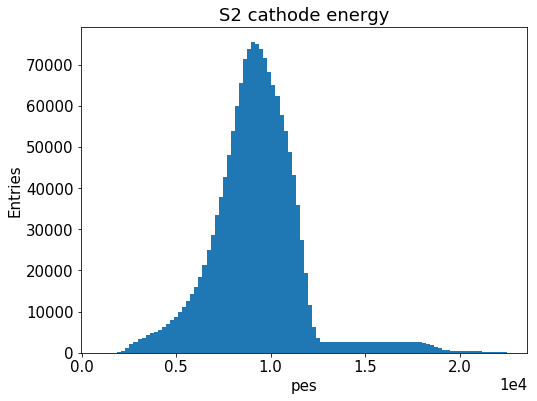

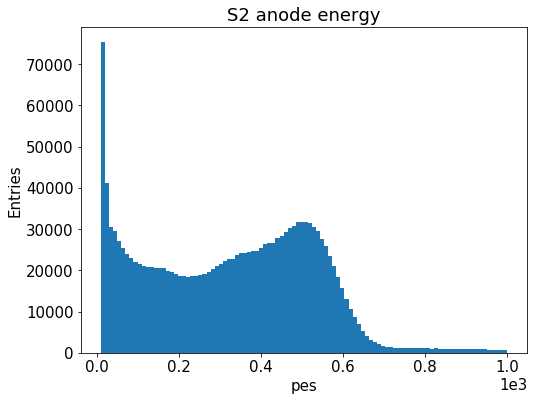

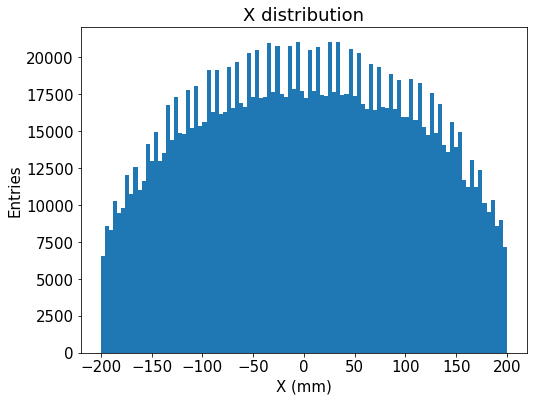

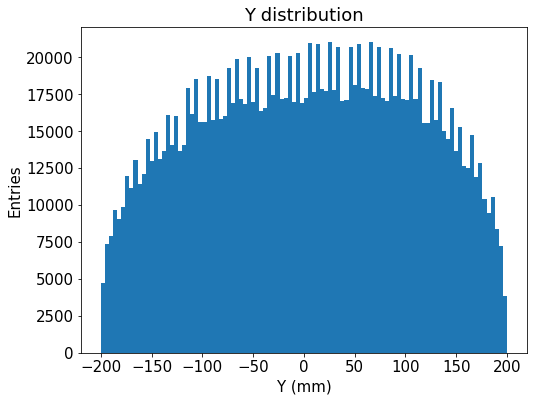

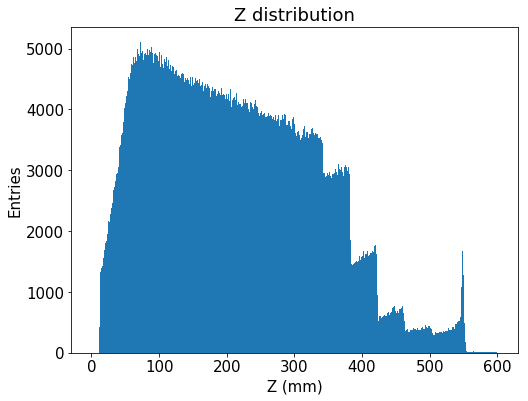

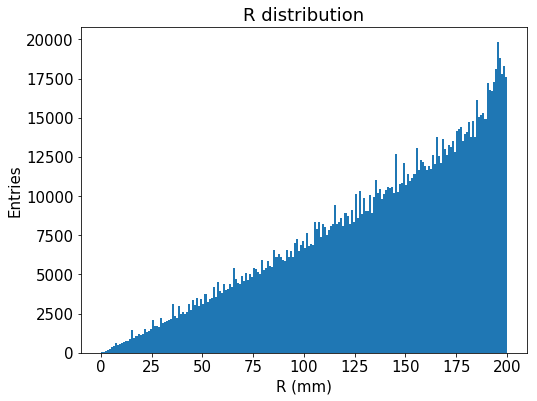

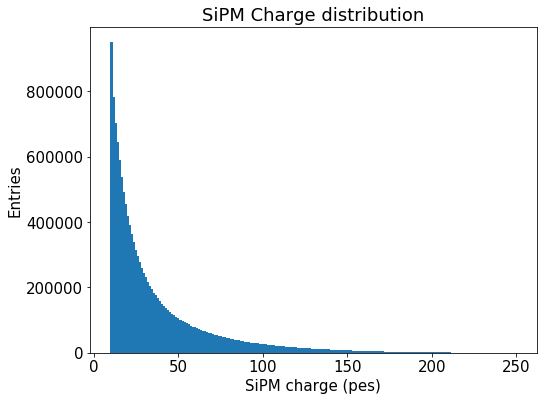

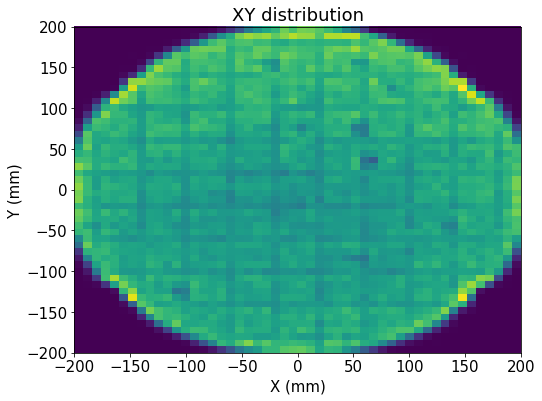

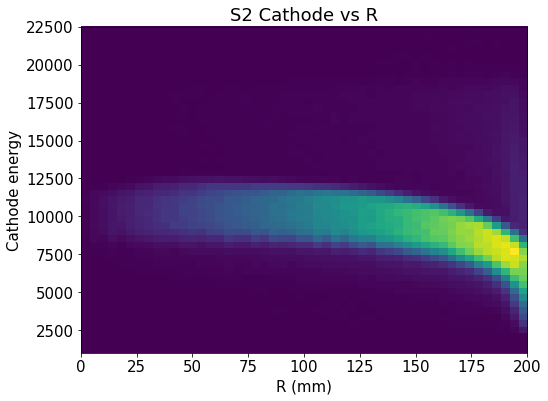

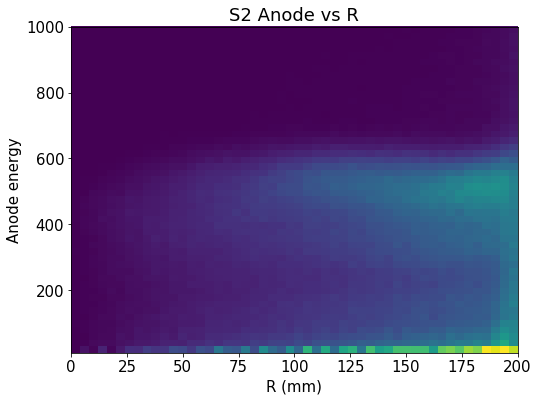

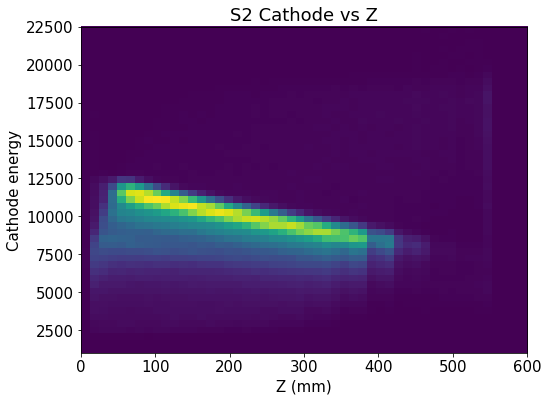

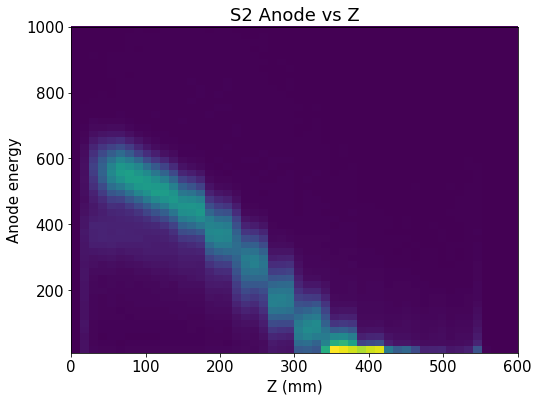

In [10]:
R = np.sqrt(mapDST.X**2 + mapDST.Y**2)

plot_var(s2ec = mapDST.EC, s2ea = mapDST.EA, x = mapDST.X, y = mapDST.Y, \
         z = mapDST.Z, r = R, sipmC = mapDST.SensorQ, nsipm = mapDST.NSiPM )

## Standard selection

In [11]:
sel = (mapDST.Z<600.) & (mapDST.EC<20000.) & (R<150.)
bins = 40
xyrange = [-200,200]
zrange = [0., 500.]
rrange =[0,200.]
erange = [mapDST.EC[sel].min(),mapDST.EC[sel].mean()+2.*mapDST.EC[sel].std()]

## Calculate lifetime correction 

Energy at z=0 = 12221.6 +- 5.3
Lifetime      = 1104.9 +- 2.9
Chi2          = 0.02          


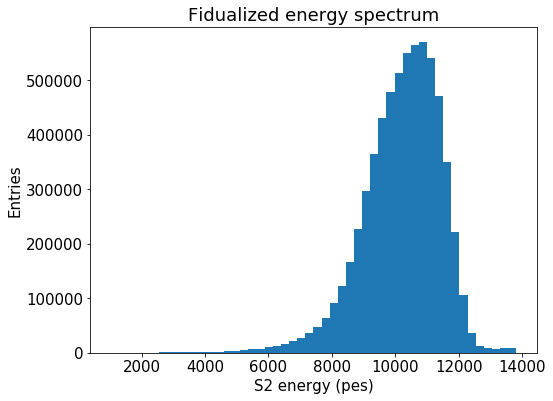

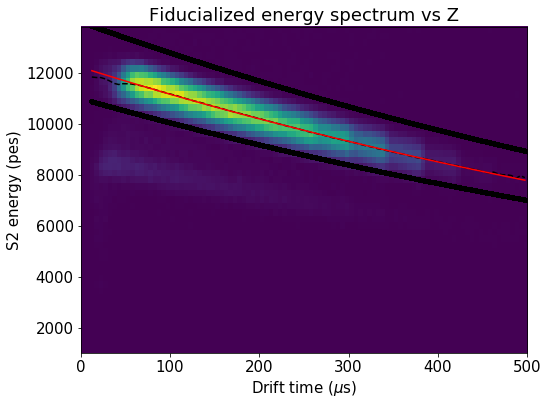

In [12]:
ZCorr = lifetime_calculation(mapDST.Z[sel], zrange, mapDST.EC[sel], erange)


## Check lifetime corrected spectrum

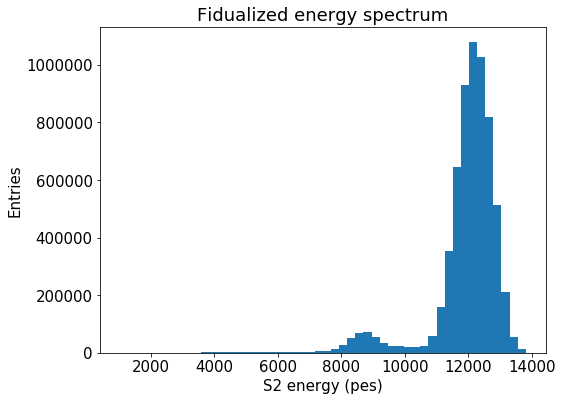

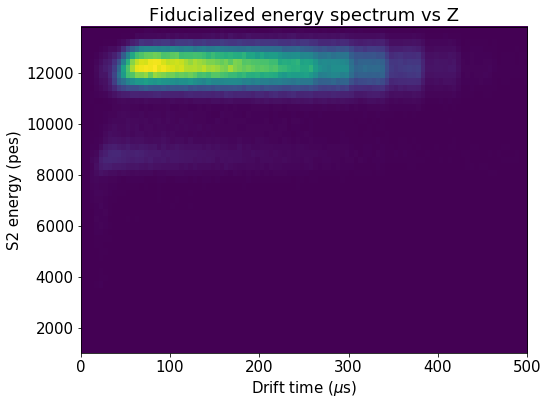

In [13]:
hist(ZCorr(mapDST.Z[sel]).value*mapDST.EC[sel], 50, erange)
labels("S2 energy (pes)", "Entries", "Fidualized energy spectrum")
hist2d(mapDST.Z[sel], ZCorr(mapDST.Z[sel]).value*mapDST.EC[sel], (100, 50), range=(zrange, erange))    
labels("Drift time ($\mu$s)", "S2 energy (pes)", "Fiducialized energy spectrum vs Z")

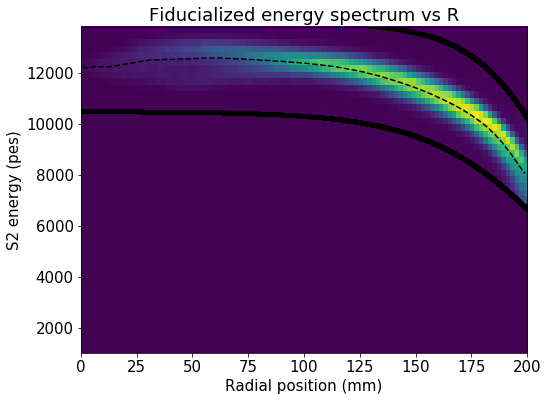

In [14]:
#low_cut   = rfun(r, 11000, 0.000009)
#high_cut  = rfun(r, 14500, 0.000004)

low_cut   = 10500 *(1/(1 + np.exp((R-216)/29)))
high_cut  = 14000 *(1/(1 + np.exp((R-220)/20)))

sel = (mapDST.Z<600.) & (mapDST.EC<20000.) & coref.in_range(ZCorr(mapDST.Z).value*mapDST.EC, low_cut, high_cut) # remove low and high E background

hist2d(R[sel], ZCorr(mapDST.Z[sel]).value*mapDST.EC[sel], (100, 50), range=(rrange, erange))
labels("Radial position (mm)", "S2 energy (pes)", "Fiducialized energy spectrum vs R")

x_prof, y_prof, u_y = fitf.profileX(R[sel], ZCorr(mapDST.Z[sel]).value*mapDST.EC[sel], 100, xrange=rrange)

plt.plot(x_prof, y_prof, profOpt)
plt.plot(R,  low_cut, "k.")
plt.plot(R, high_cut, "k.")

## Make PMT profile

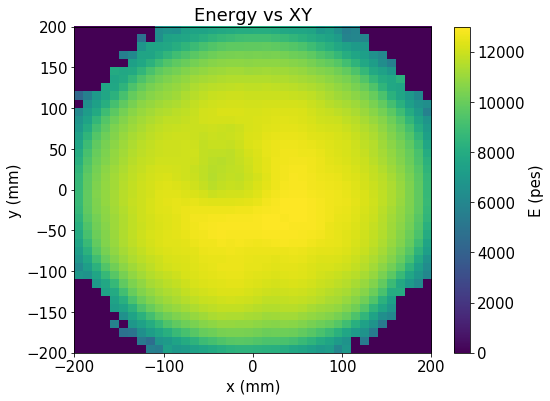

In [15]:
sel = (mapDST.Z<300.) 
sel = sel & coref.in_range(ZCorr(mapDST.Z).value*mapDST.EC, low_cut, high_cut) 
#sel = sel & coref.in_range(ZCorr(z).value*s2ec, low_cut, high_cut) 

(xc, yc, Ec, Ece), _, cb = \
hist2d_profile(mapDST.X[sel], mapDST.Y[sel], ZCorr(mapDST.Z[sel]).value*mapDST.EC[sel], 40, 40, xyrange, xyrange)
cb.set_label("E (pes)")
labels("x (mm)", "y (mm)", "Energy vs XY")

## Make SiPM profile

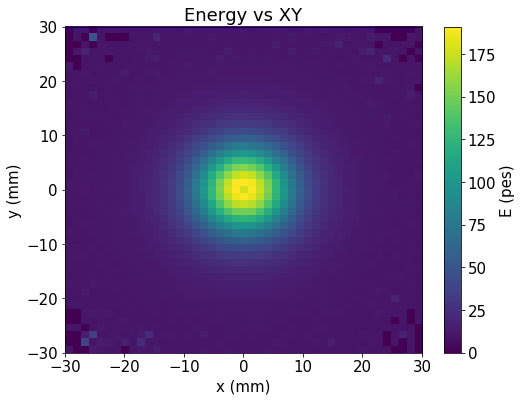

In [16]:
sel = coref.in_range(mapDST.Z, 000., 50.)
sel = sel & coref.in_range(ZCorr(mapDST.Z).value*mapDST.EC, low_cut, high_cut) 
sipm_xyrange = (-30., 30.)

DX = mapDST.X.values - DataSiPM.X.values[mapDST.SensorID.values]
DY = mapDST.Y.values - DataSiPM.Y.values[mapDST.SensorID.values]
E_Sipm = mapDST.SensorQ.values
(xc, yc, Ec, Ece), _, cb = \
hist2d_profile(DX[sel], DY[sel], E_Sipm[sel], 45, 45, sipm_xyrange, sipm_xyrange)
cb.set_label("E (pes)")
labels("x (mm)", "y (mm)", "Energy vs XY")

X DIMENSION
[[Model]]
    (Model(constant) + Model(voigt))
[[Fit Statistics]]
    # function evals   = 28
    # data points      = 45
    # variables        = 4
    chi-square         = 14601.261
    reduced chi-square = 356.128
    Akaike info crit   = 268.199
    Bayesian info crit = 275.426
[[Variables]]
    c:           411.055902 +/- 0        (0.00%) (init= 0)
    sigma:       3.92689551 +/- 0        (0.00%) (init= 4.333333)
    center:     -2.0993e-15 +/- 0        (0.00%) (init=-2.099331e-15)
    amplitude:   40076.0929 +/- 0        (0.00%) (init= 62215.98)
    gamma:       3.92689551 +/- 0        (0.00%)  == 'sigma'
    fwhm:        14.1419681 +/- 0        (0.00%)  == '3.6013100*sigma'
    height:      4071.42197 +/- 0        (0.00%)  == '0.3989423*amplitude/max(1.e-15, sigma)'

Y DIMENSION
[[Model]]
    (Model(constant) + Model(voigt))
[[Fit Statistics]]
    # function evals   = 28
    # data points      = 45
    # variables        = 4
    chi-square         = 22112.989
    red

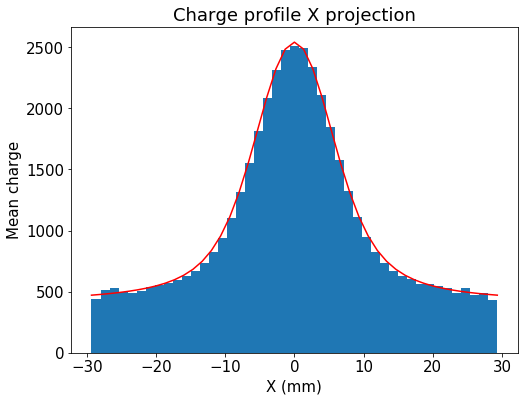

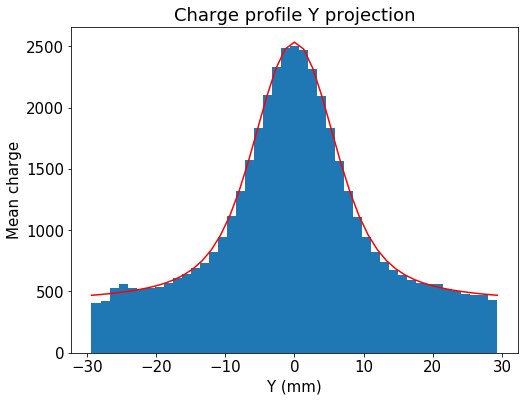

In [17]:
sigma, constant = diff_calculation(xc,yc,Ec,Ece,verbosity = True)

In [19]:
print(sigma)

[3.9268955173044038, 3.9596654925377406]


## Make SiPM profile for different Z + transversal diffusion

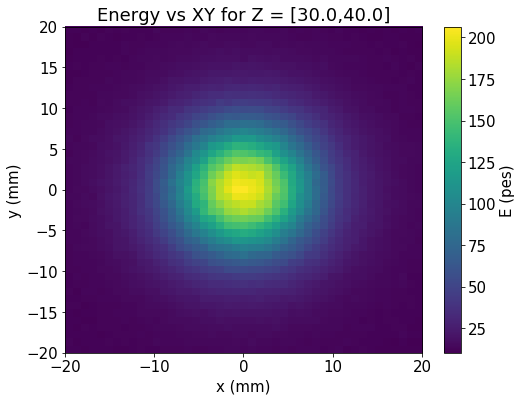

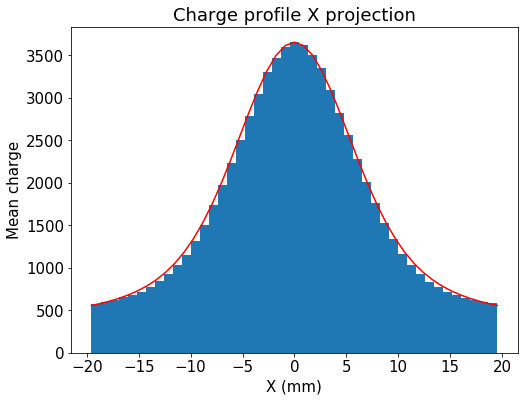

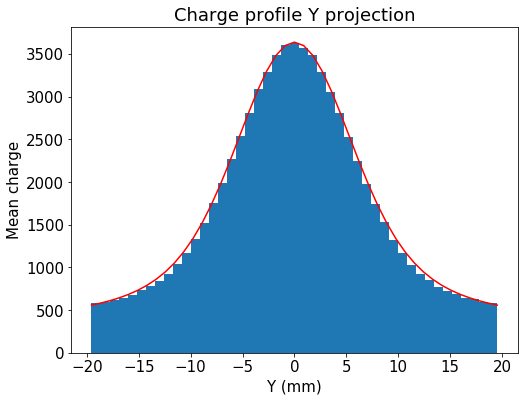

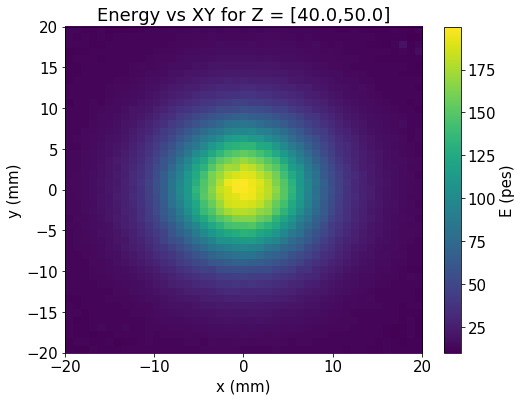

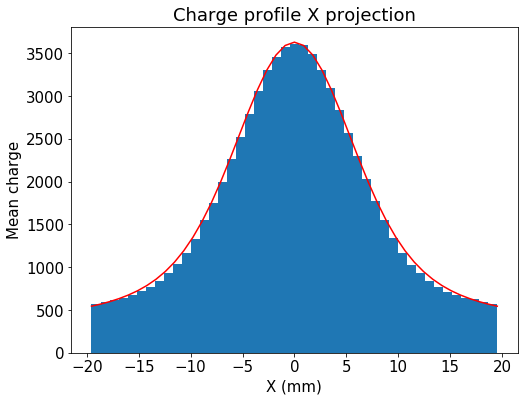

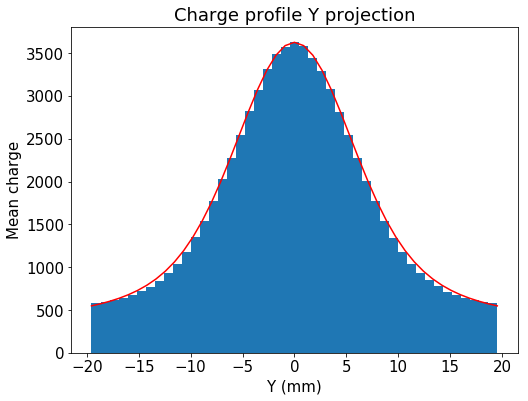

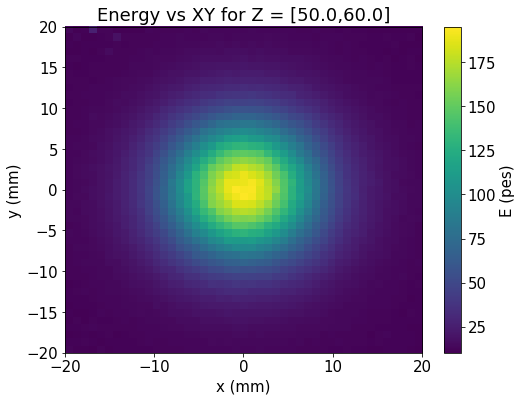

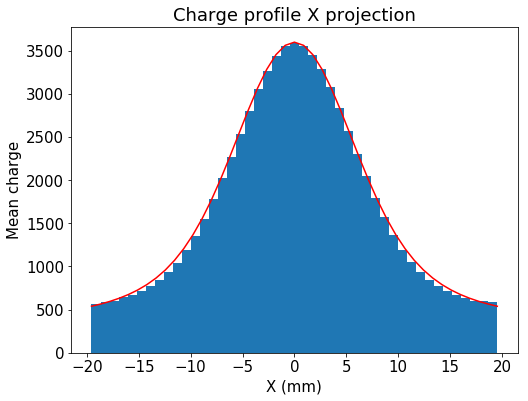

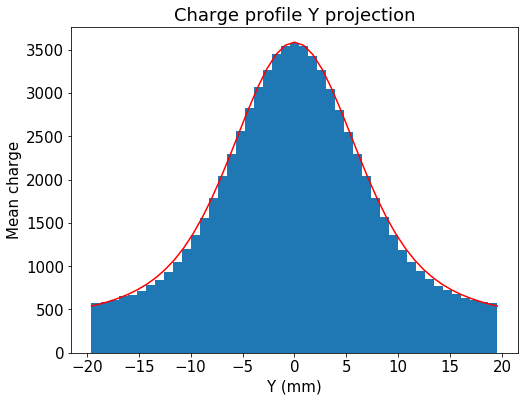

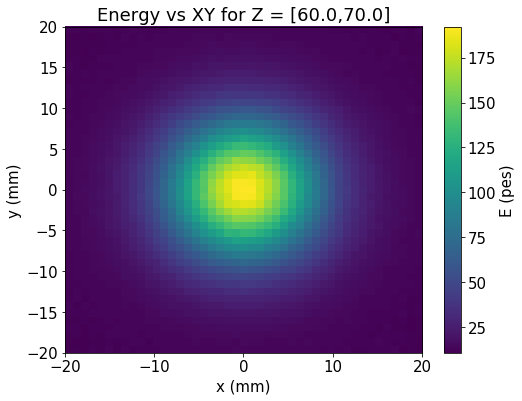

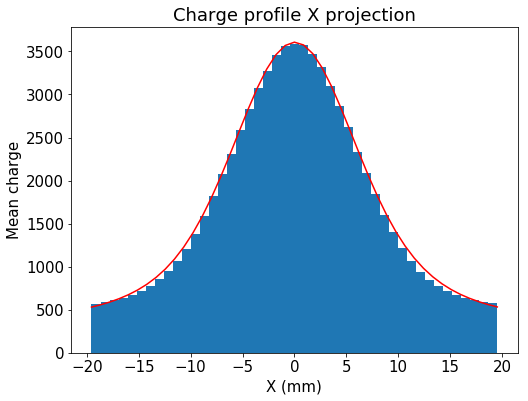

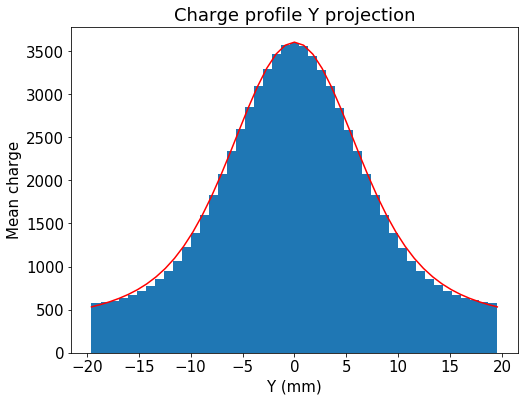

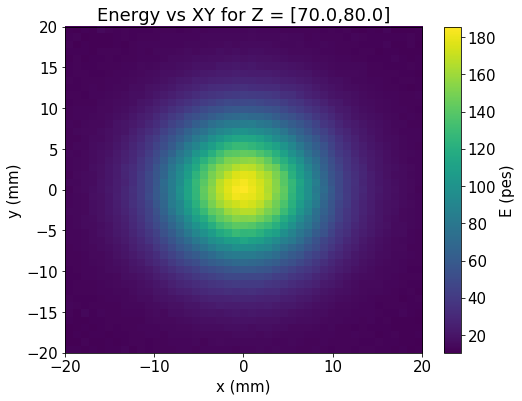

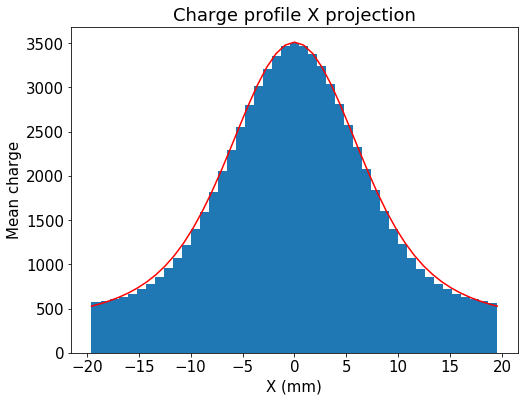

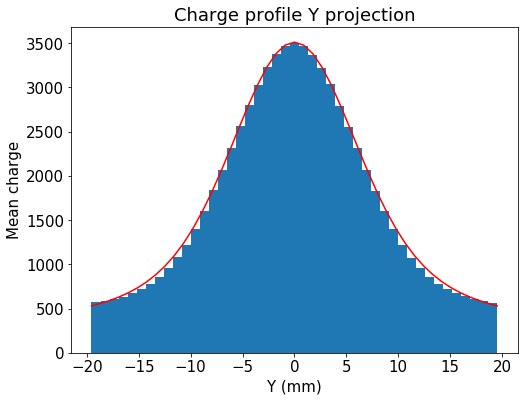

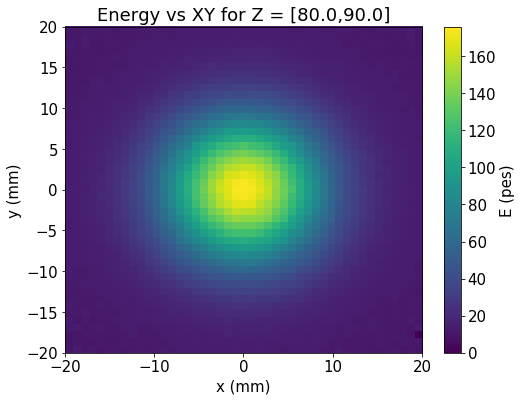

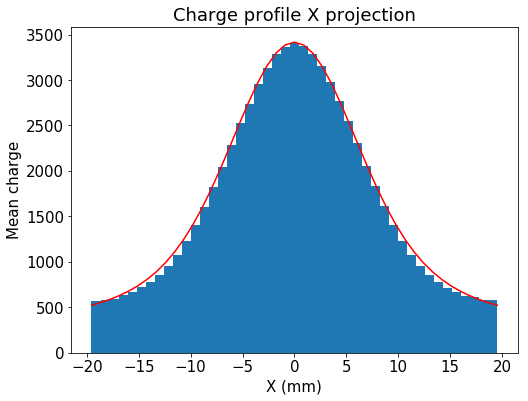

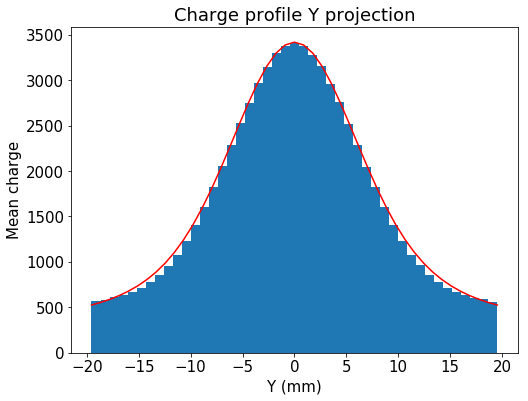

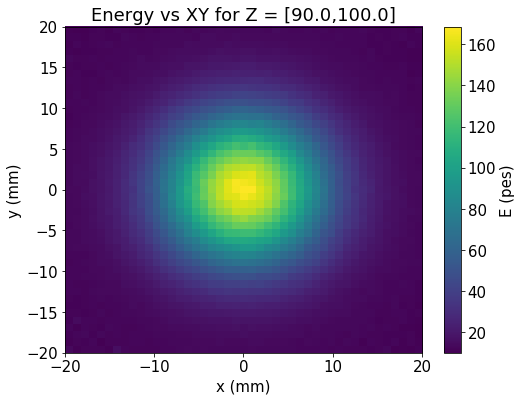

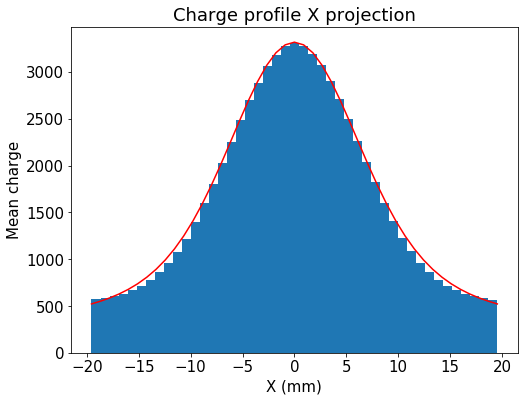

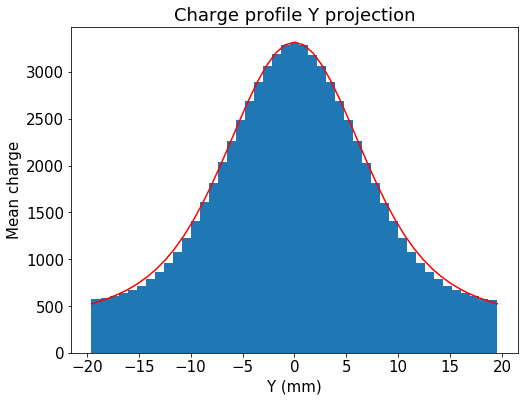

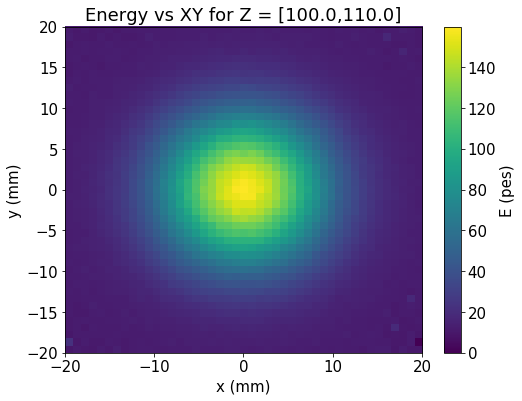

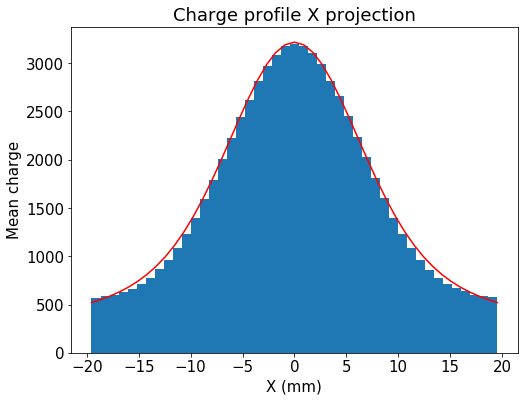

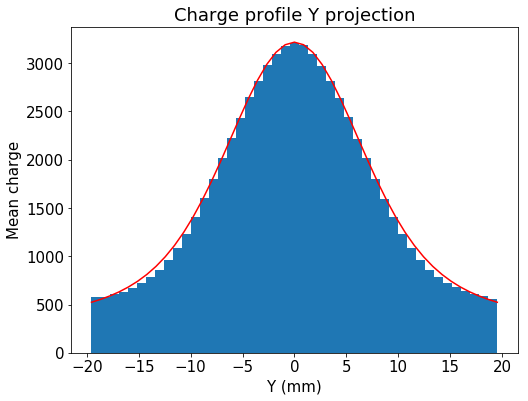

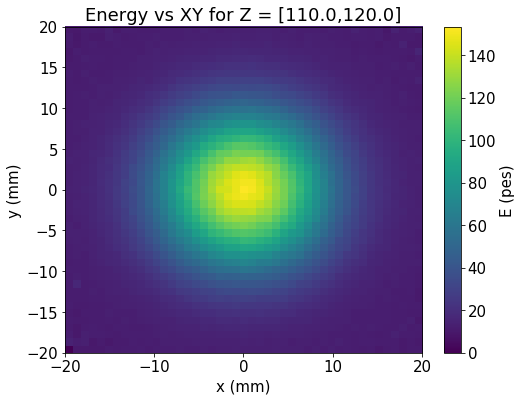

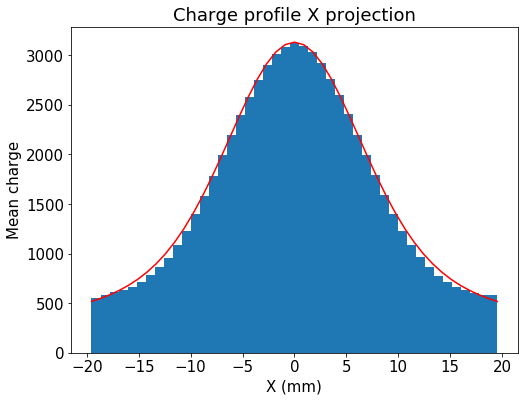

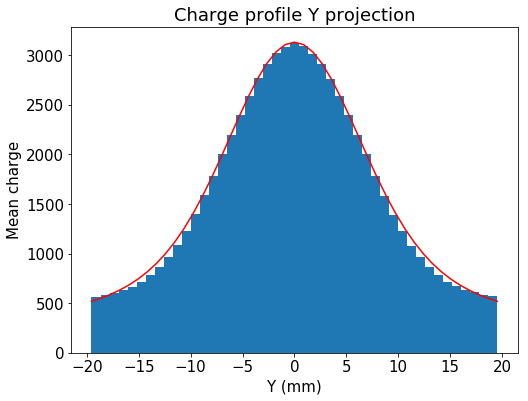

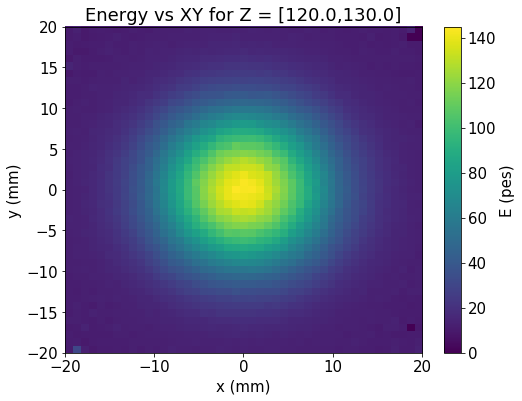

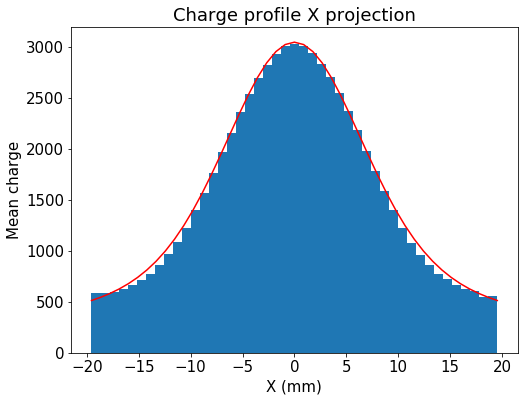

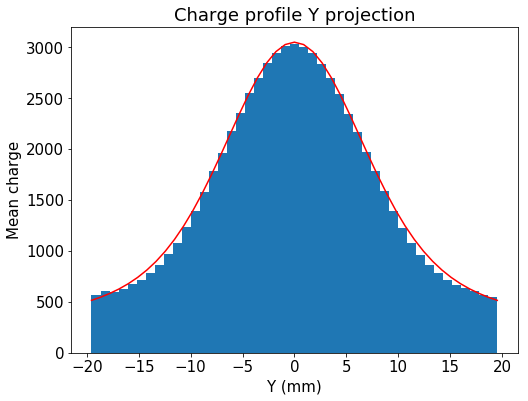

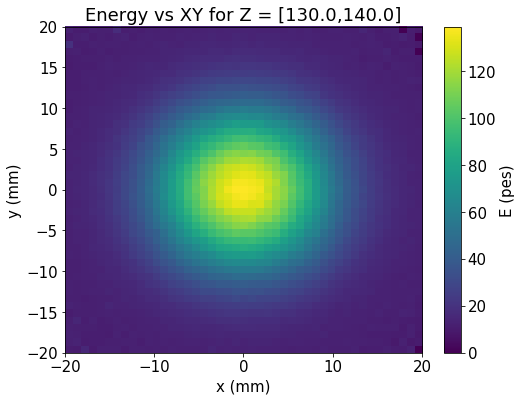

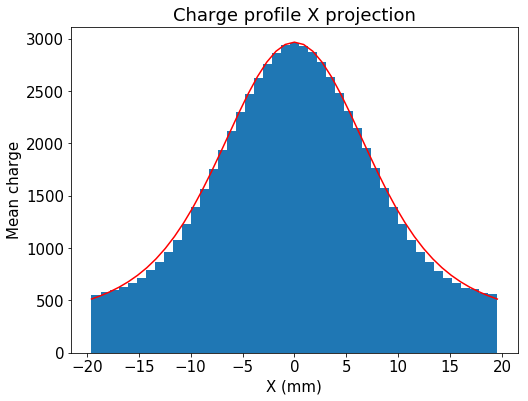

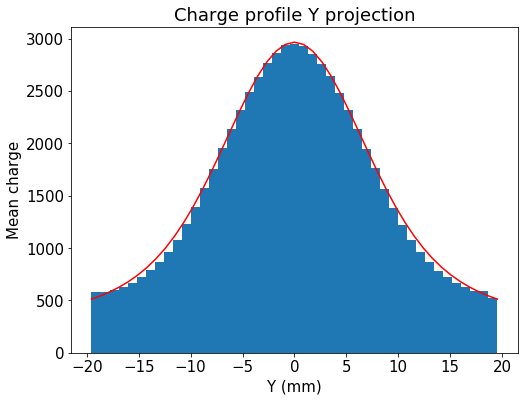

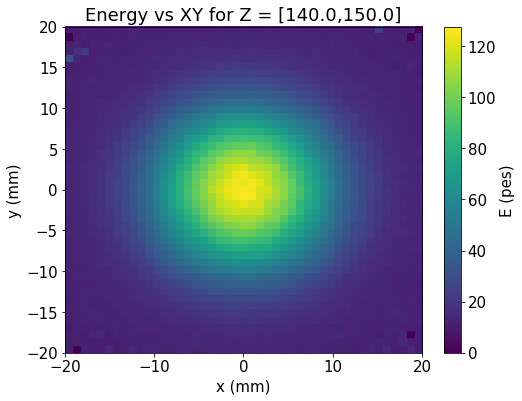

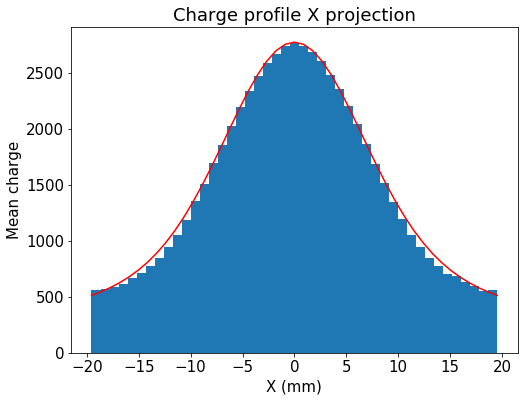

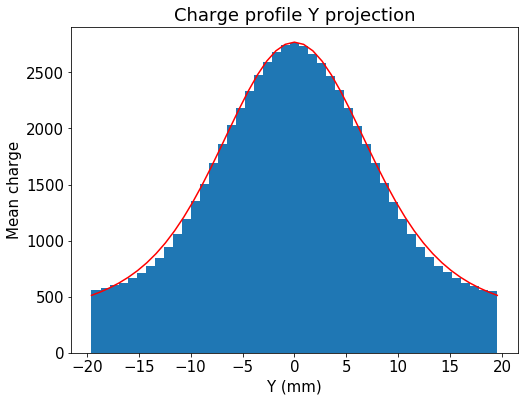

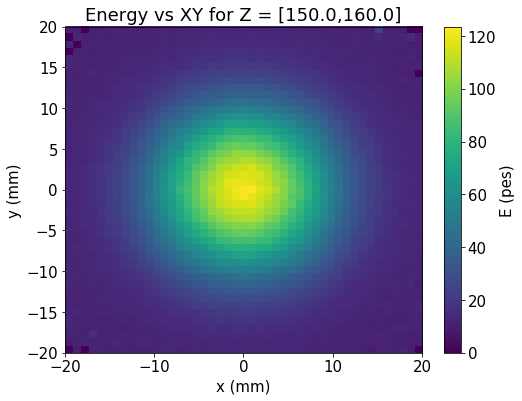

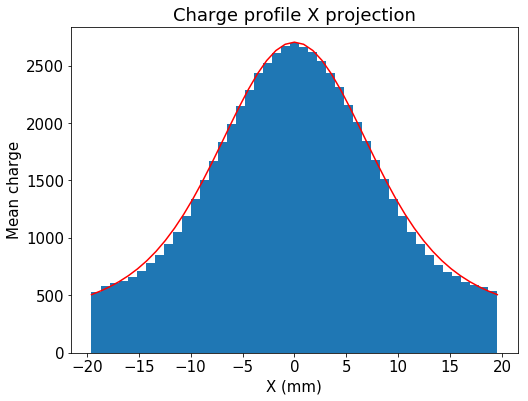

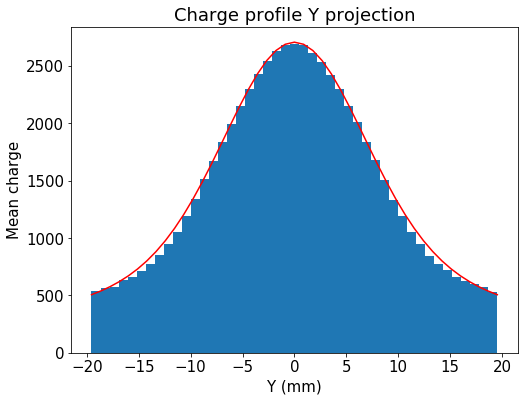

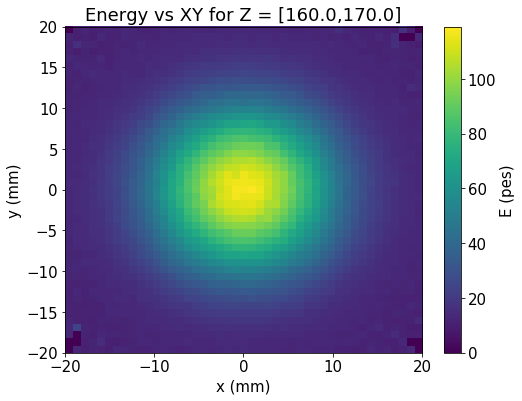

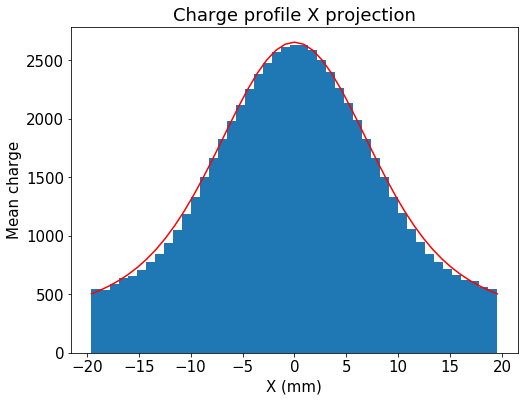

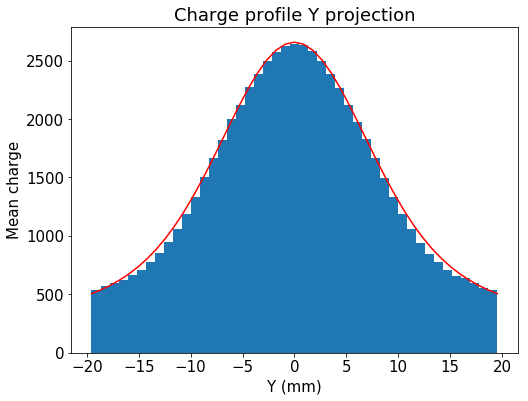

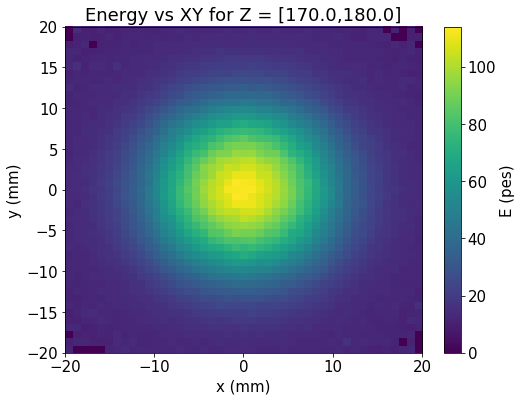

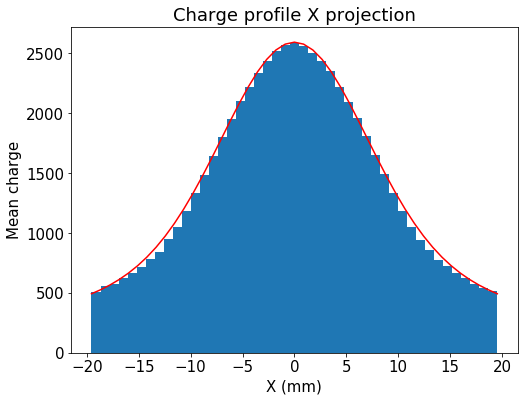

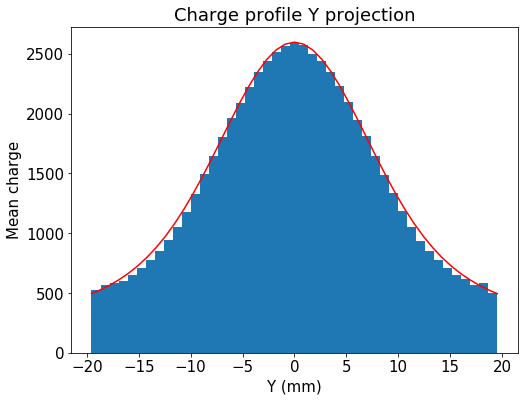

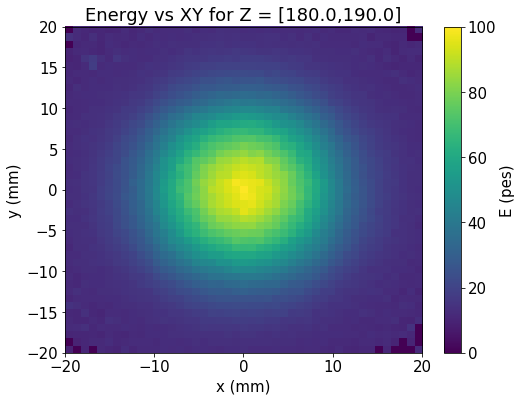

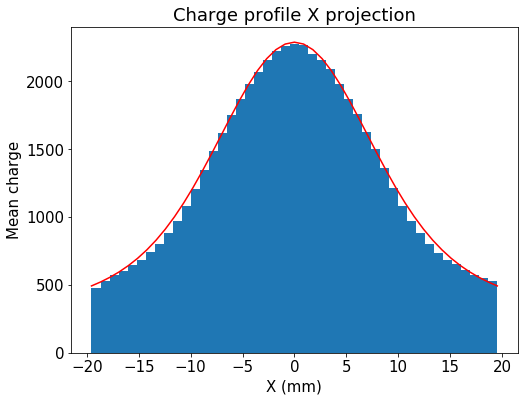

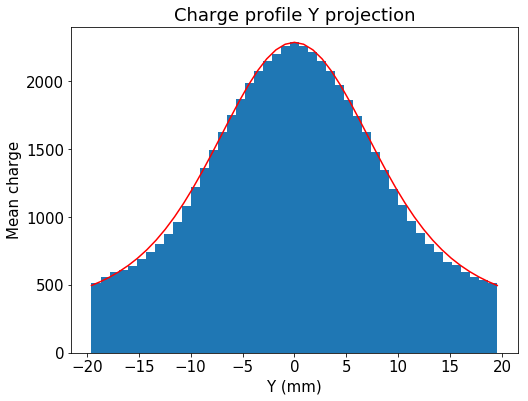

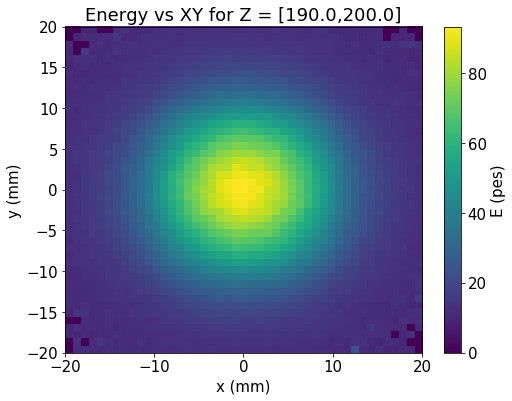

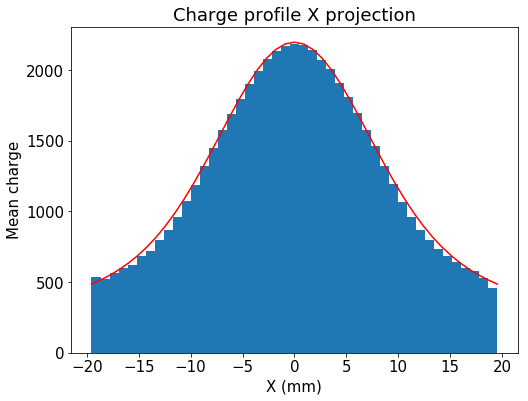

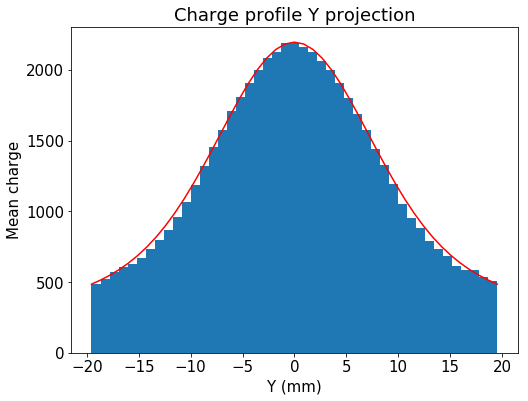

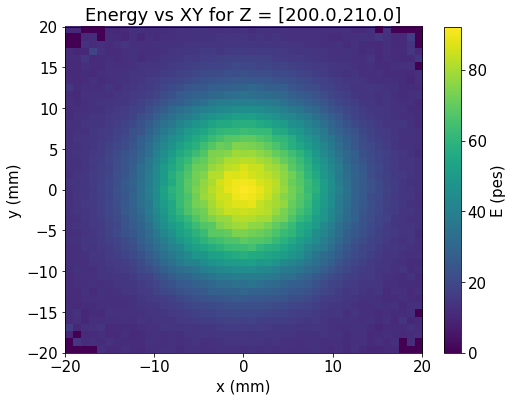

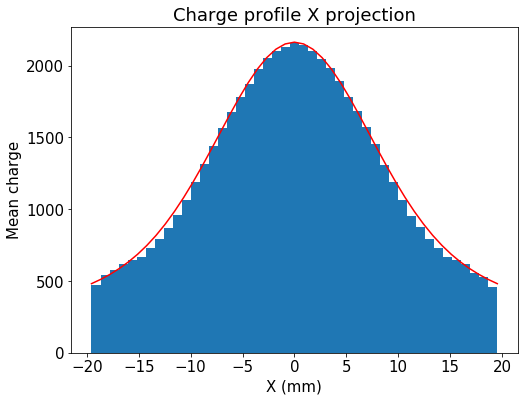

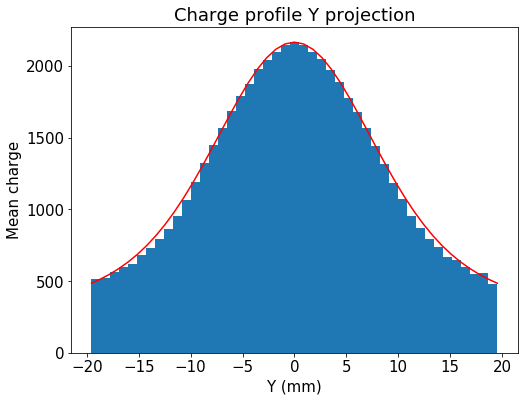

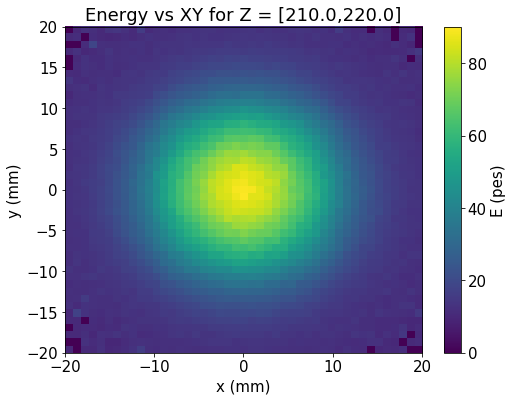

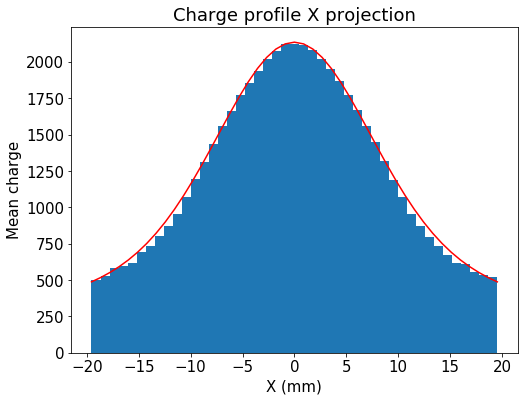

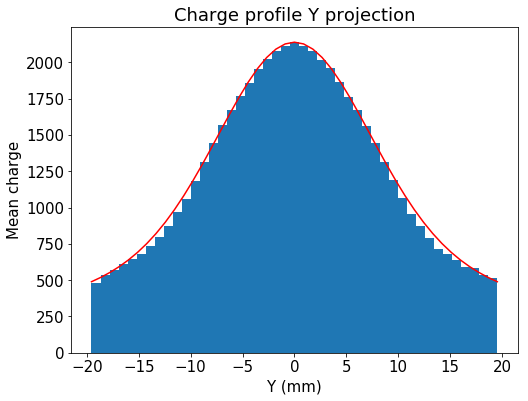

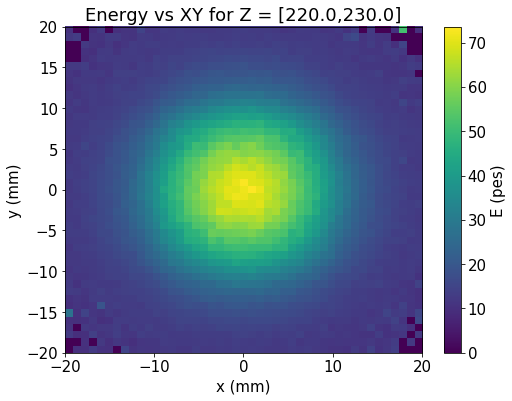

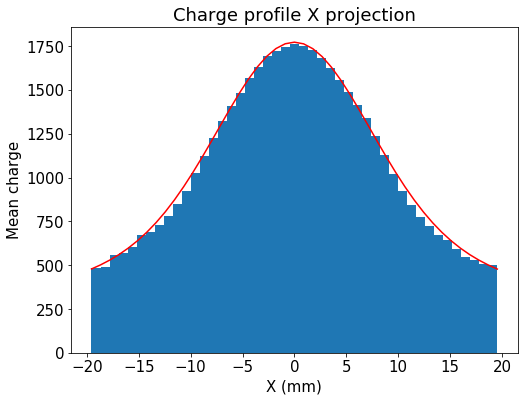

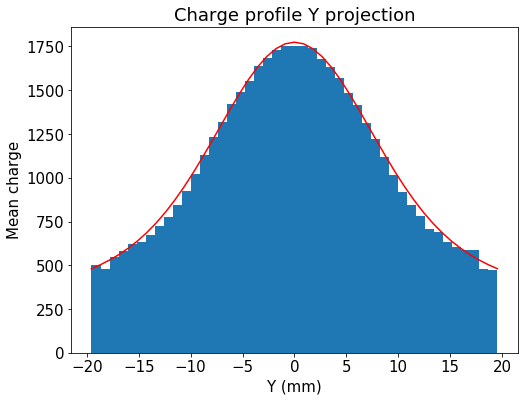

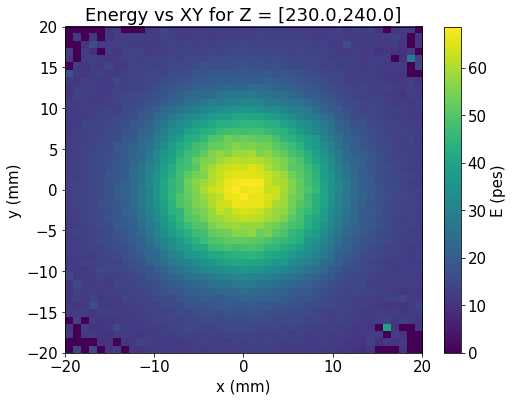

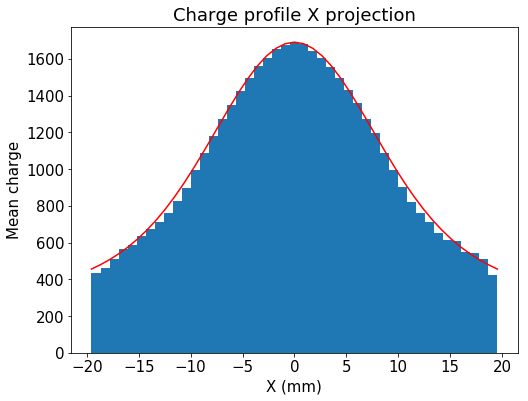

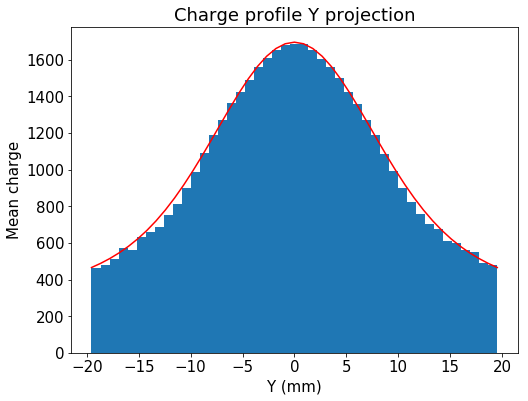

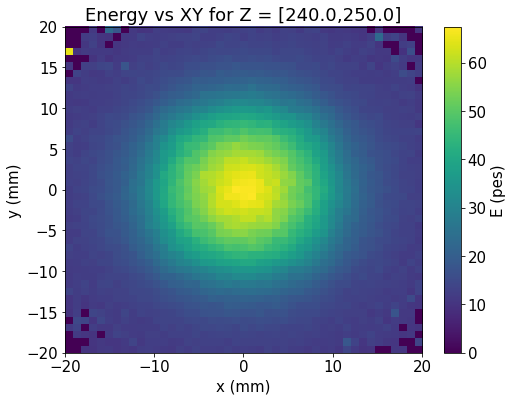

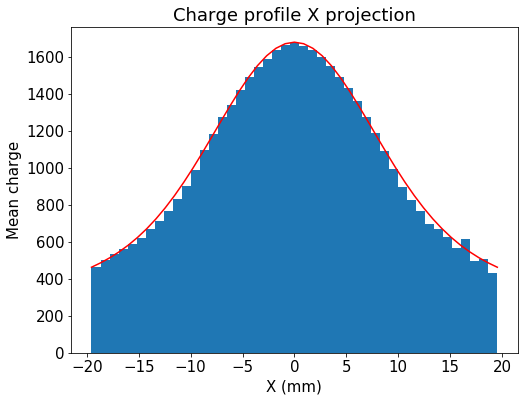

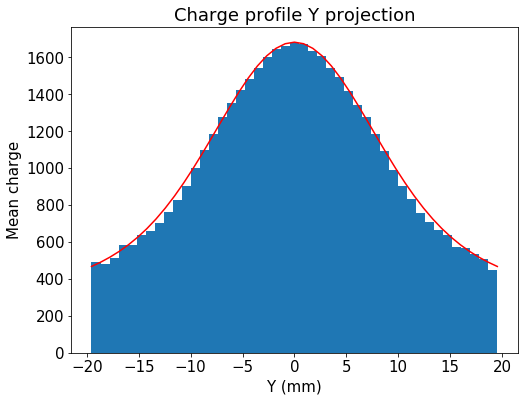

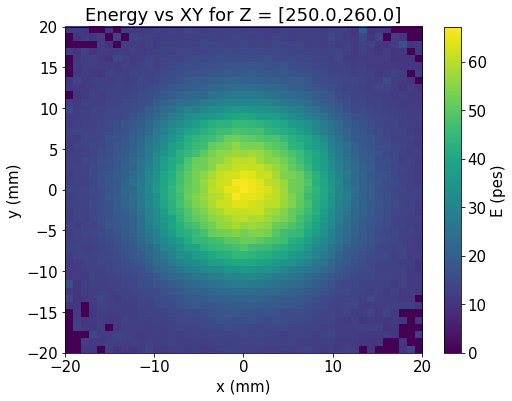

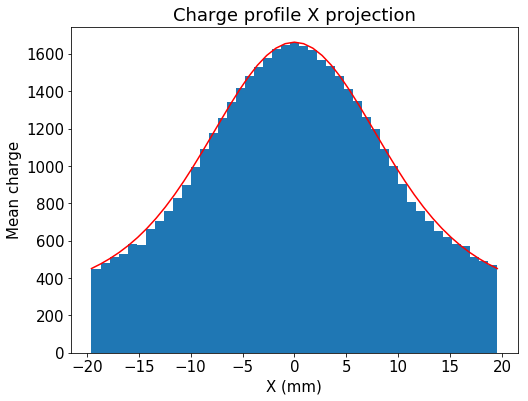

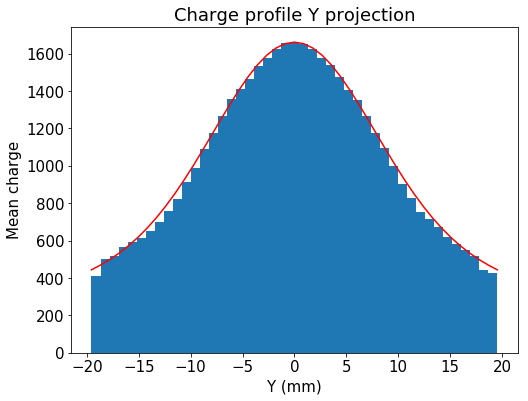

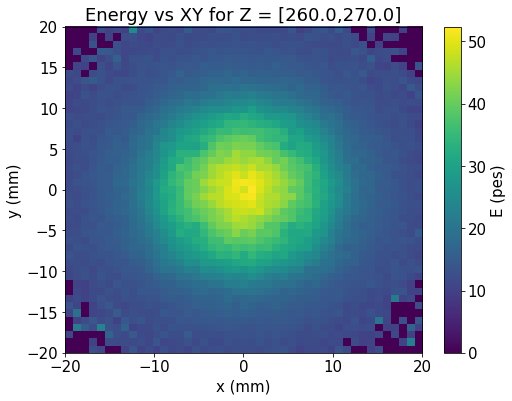

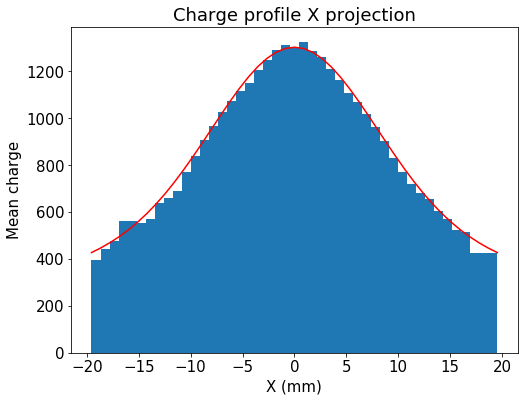

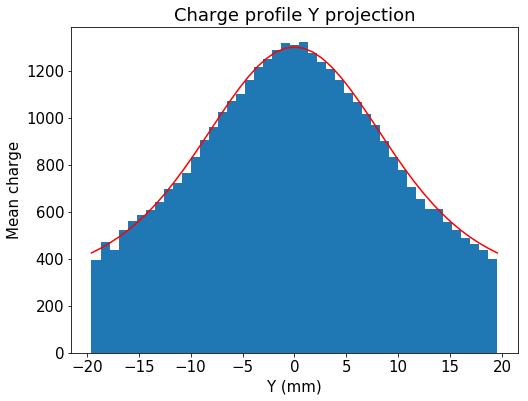

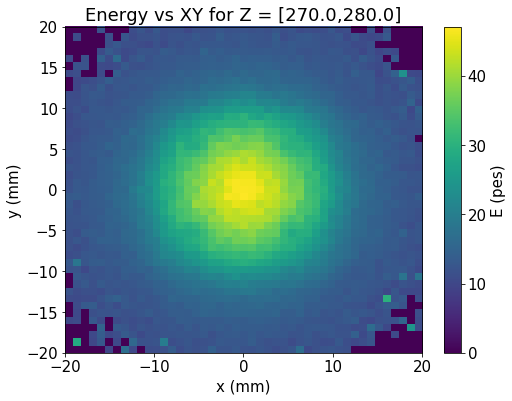

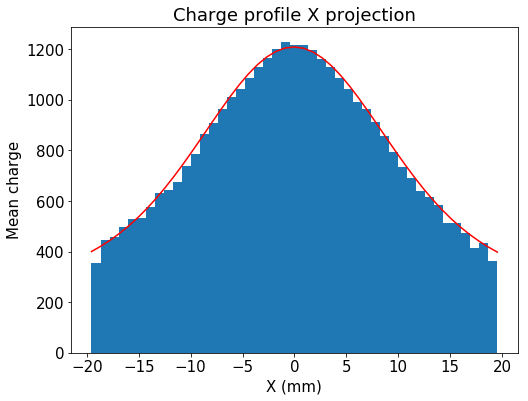

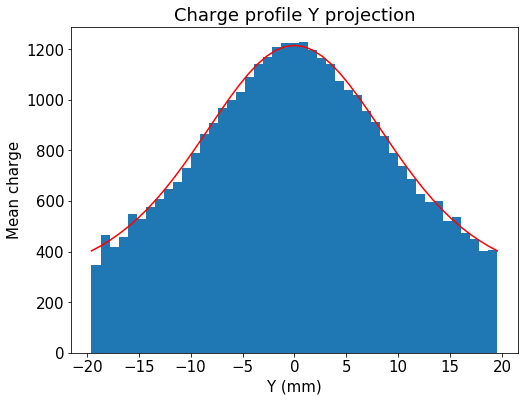

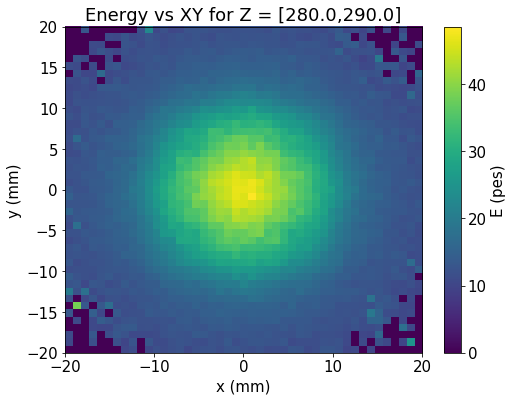

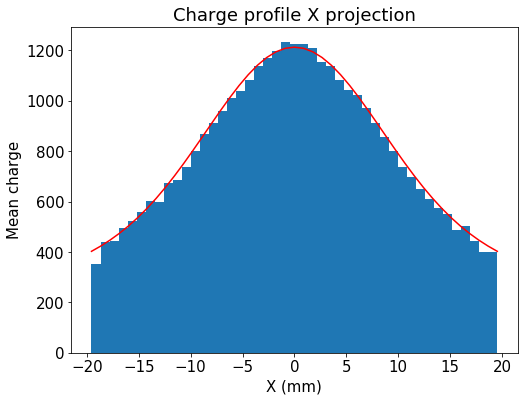

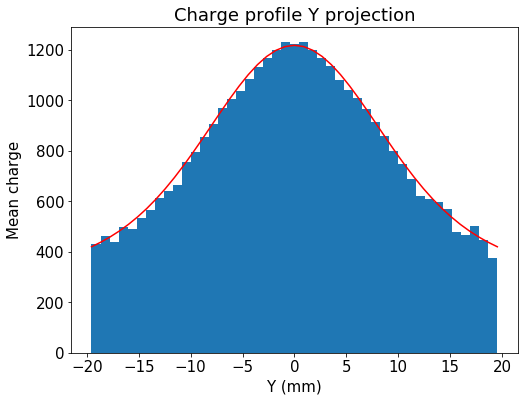

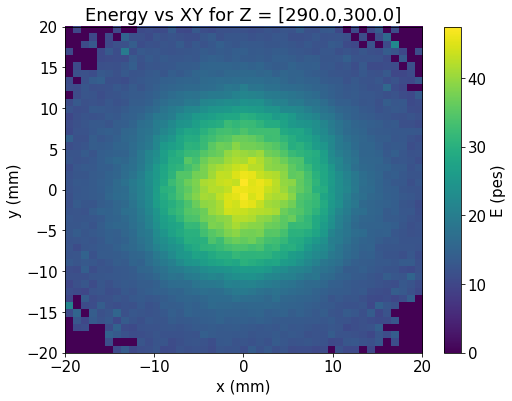

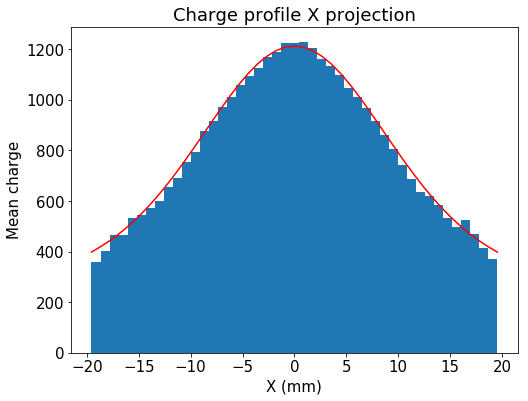

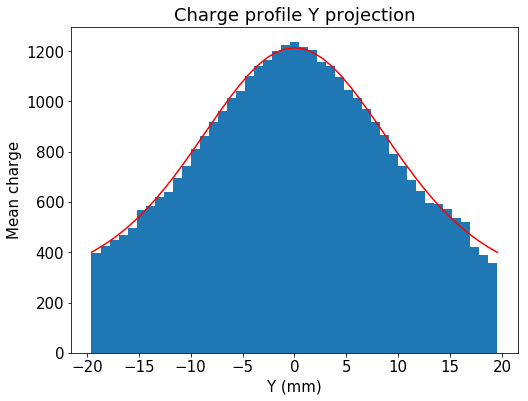

In [20]:
step = 10
z_int = 10
z_scan = np.arange(30.,300.,step)

sipm_xyrange = (-20., 20.)

DX = mapDST.X.values - DataSiPM.X.values[mapDST.SensorID.values]
DY = mapDST.Y.values - DataSiPM.Y.values[mapDST.SensorID.values]
E_Sipm = mapDST.SensorQ.values

sigmaAll = []
constantAll = []

for i,z in enumerate(z_scan):
    sel = coref.in_range(mapDST.Z, z, z+z_int)
    sel = sel & coref.in_range(ZCorr(mapDST.Z).value*mapDST.EC, low_cut, high_cut) 
    sel = sel & (mapDST.NSiPM>=4)
    (xc, yc, Ec, Ece), _, cb = \
    hist2d_profile(DX[sel], DY[sel], E_Sipm[sel], 45, 45, sipm_xyrange, sipm_xyrange)
    cb.set_label("E (pes)")
    labels("x (mm)", "y (mm)", "Energy vs XY for Z = [{0},{1}]".format(z, z+z_int))
    sigma, constant = diff_calculation(xc,yc,Ec,Ece)
    sigmaAll.append(sigma)
    constantAll.append(sigma)

In [22]:
sigmaBackup = sigmaAll

In [24]:
sigmaX = [item[0] for item in sigmaBackup[:]]
sigmaY = [item[1] for item in sigmaBackup[:]]

print(sigmaX)

[3.9107887927046336, 3.9980617208151186, 4.0732087443995288, 4.1690958760276864, 4.2720161666670107, 4.3701852605053464, 4.4587657176875428, 4.5542807635794746, 4.6424164976497631, 4.742781010987339, 4.811961073740374, 4.9223839367804549, 5.0236885757493015, 5.0981015563089613, 5.2138532576284922, 5.2556729796649426, 5.341389278513236, 5.4350123876246395, 5.4749729041198654, 5.4944104304347237, 5.6585754416470815, 5.6628368745454845, 5.7603666926842481, 5.9881195620673422, 6.3277740485864715, 6.3501938106855356, 6.4191497177327657]


In [25]:
def sqrt(z,diff,c):
    return np.sqrt(c**2+(2*diff*z/10))

### Diffusion fit

Diffusion (mm/sqrt(cm)) = 1.0 +- 0.0


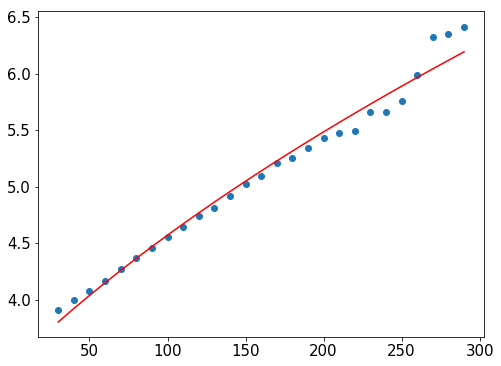

In [32]:
#z_scan2 = np.arange(25.,300.,25)

plt.scatter(z_scan, sigmaX)
#plt.plot(z_scan2, sigmaY, color='red')
seed = 1.,1.
f = fitf.fit(sqrt, z_scan, sigmaX, seed=seed)
plt.plot(z_scan, f.fn(z_scan), fitOpt)
print("Diffusion (mm/sqrt(cm)) = {:.1f} +- {:.1f}".format(np.sqrt(2*f.values[0]), f.errors[0]))

## Make SiPM profile for different R

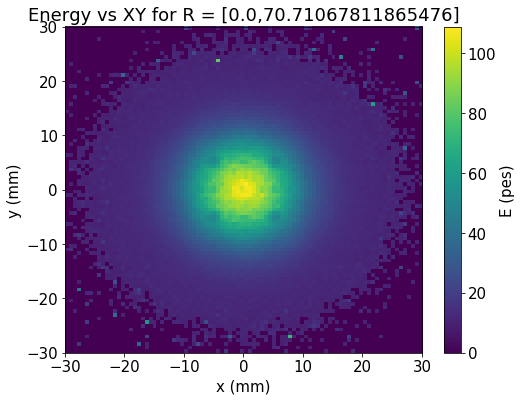

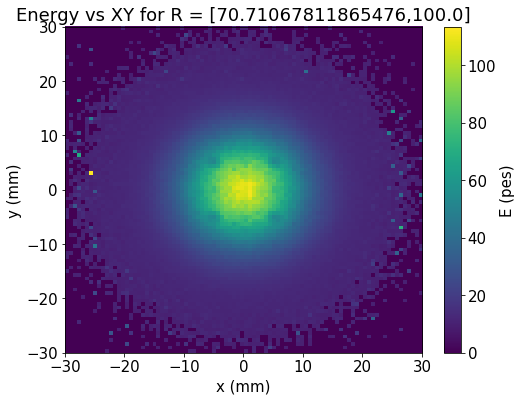

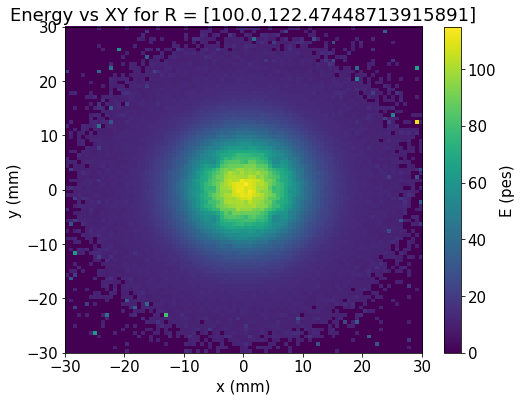

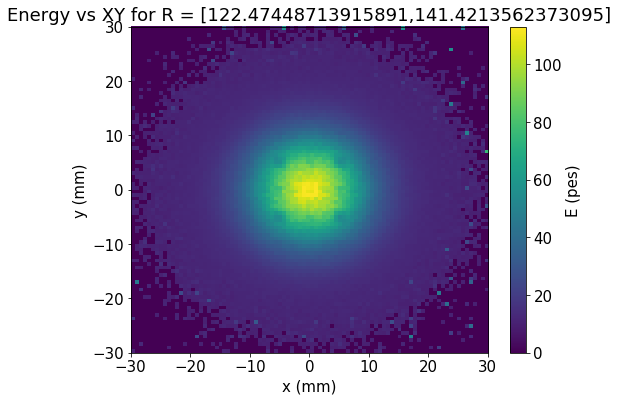

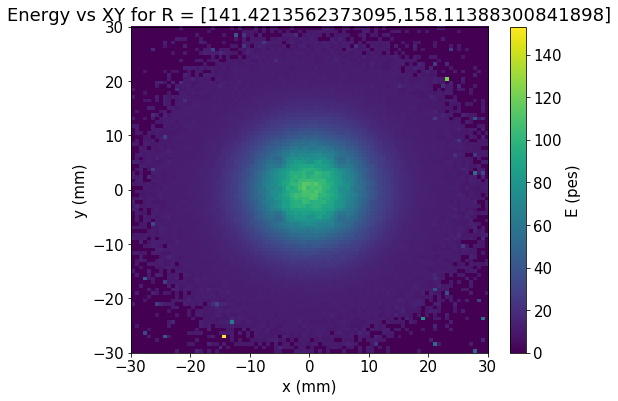

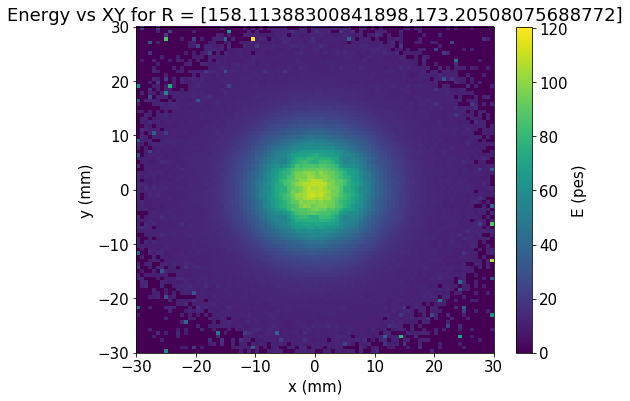

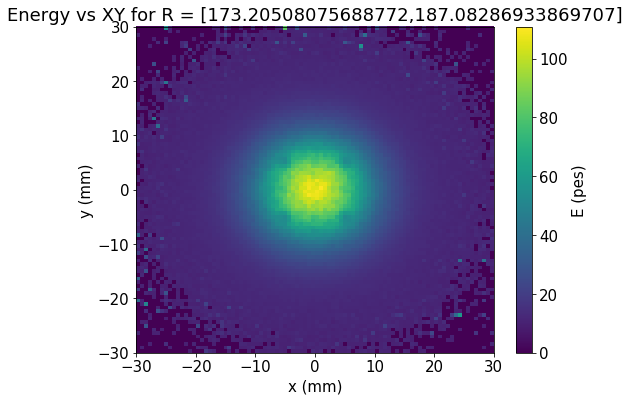

In [31]:
step = 5000
r_int = 25
r_scan = np.arange(0.,200.**2,step)
r_scan = [np.sqrt(i) for i in np.arange(0., 40000, 5000)]
sipm_xyrange = (-30., 30.)

DX = mapDST.X.values - DataSiPM.X.values[mapDST.SensorID.values]
DY = mapDST.Y.values - DataSiPM.Y.values[mapDST.SensorID.values]
E_Sipm = mapDST.SensorQ.values

#plt.figure(figsize=(8,12))

for i,r in enumerate(r_scan[:-1]):
    sel = coref.in_range(R, r, r_scan[i+1])
    sel = sel & coref.in_range(ZCorr(mapDST.Z).value*mapDST.EC, low_cut, high_cut) 
    sel = sel & (mapDST.NSiPM>=4)
    #    print(i)
#    plt.subplot(len(z_scan)//2, 2, i+1)
    (xc, yc, Ec, Ece), _, cb = \
    hist2d_profile(DX[sel], DY[sel], E_Sipm[sel], 90, 90, sipm_xyrange, sipm_xyrange)
    cb.set_label("E (pes)")
    labels("x (mm)", "y (mm)", "Energy vs XY for R = [{0},{1}]".format(r, r_scan[i+1]))

In [30]:
print(r_scan)


[0.0, 70.710678118654755, 100.0, 122.47448713915891, 141.42135623730951, 158.11388300841898, 173.20508075688772, 187.08286933869707]


In [ ]:
sel = (z<500.) & (s2ec<20000.) & (np.sqrt(x*x+y*y)<198.)
hist2d(x[sel], y[sel], bins, [xyrange, xyrange])
labels("X (mm)", "Y(mm)", "XY distribution")